# Experimentos - Función Objetivo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

import pickle
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Use latex
plt.rc("text", usetex=True)

## 1 - Sin Restricciones Adicionales

Generación de datos:

In [3]:
from src.generacion import (
    GeneradorInstancias,
    DistribucionIndependiente,
    DistribucionUniforme,
    DistribucionNormal,
)

random.seed(42)

# Generar instancias
N = 1000

generador = GeneradorInstancias(
    cantidad_trabajadores=DistribucionUniforme(5, 10),
    cantidad_ordenes=DistribucionUniforme(5, 20),
    parametros_ordenes=DistribucionIndependiente(
        DistribucionNormal(10000, 2000),
        DistribucionUniforme(3, 10),
    ),
)

instancias = [generador.generar_instancia() for _ in range(N)]

with open("datos/exp1/instancia.pkl", "wb") as f:
    pickle.dump(instancias, f)

In [3]:
with open("datos/exp1/instancia.pkl", "rb") as f:
    instancias = pickle.load(f)

Resolución (~10m):

In [5]:
from tqdm import tqdm
from src.modelo import ModeloAsignacionCuadrillas
from src.solver import ConfiguracionCPLEX


soluciones = []
for instancia in tqdm(instancias):
    modelo = ModeloAsignacionCuadrillas(instancia)
    solver = modelo.armar_solver(ConfiguracionCPLEX(sin_output=True))

    objetivo, valores = solver.resolver()

    anotada = modelo.anotar_solucion(valores)

    soluciones.append((objetivo, anotada))

with open("datos/exp1/solucion.pkl", "wb") as f:
    pickle.dump(soluciones, f)

100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s] 


In [4]:
from typing import List
from src.solucion import SolucionAnotada


with open("datos/exp1/solucion.pkl", "rb") as f:
    soluciones: List[SolucionAnotada] = pickle.load(f)

### Distribución de Función Objetivo

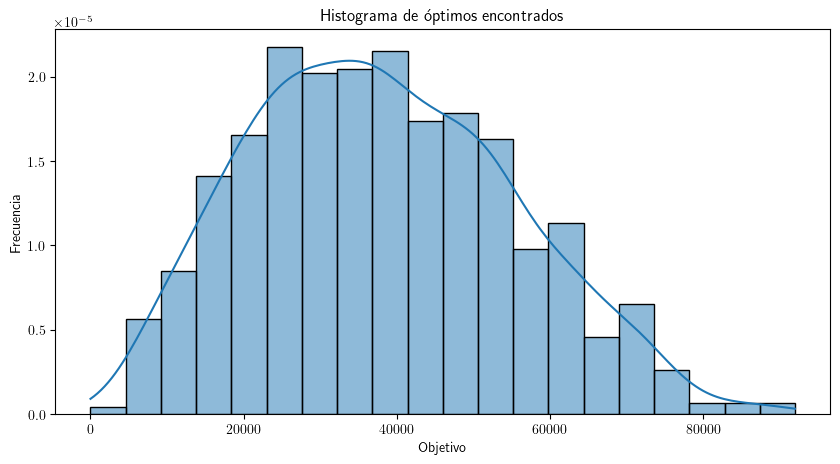

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

optimos = [obj for (obj, _) in soluciones]
sns.histplot(optimos, bins=20, ax=ax, kde=True, stat="density")

ax.set_title("Histograma de óptimos encontrados")
ax.set_xlabel("Objetivo")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/exp1/distribucion_objetivo.pdf")

plt.show()

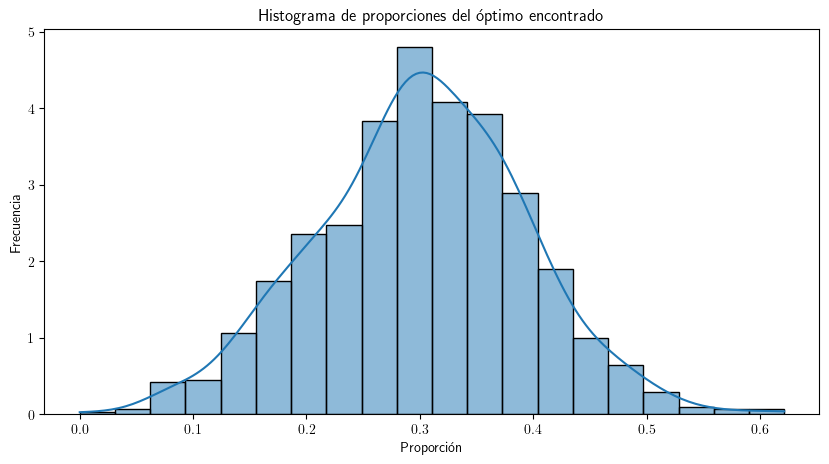

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

proporciones_optimo = [
    obj / sum(orden.beneficio for orden in instancia.ordenes)
    for instancia, (obj, _) in zip(instancias, soluciones)
]
sns.histplot(proporciones_optimo, bins=20, ax=ax, kde=True, stat="density")

ax.set_title("Histograma de proporciones del óptimo encontrado")
ax.set_xlabel("Proporción")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/exp1/distribucion_proporcion_objetivo.pdf")

plt.show()

### Distribución de Cantidad y Proporción de Órdenes

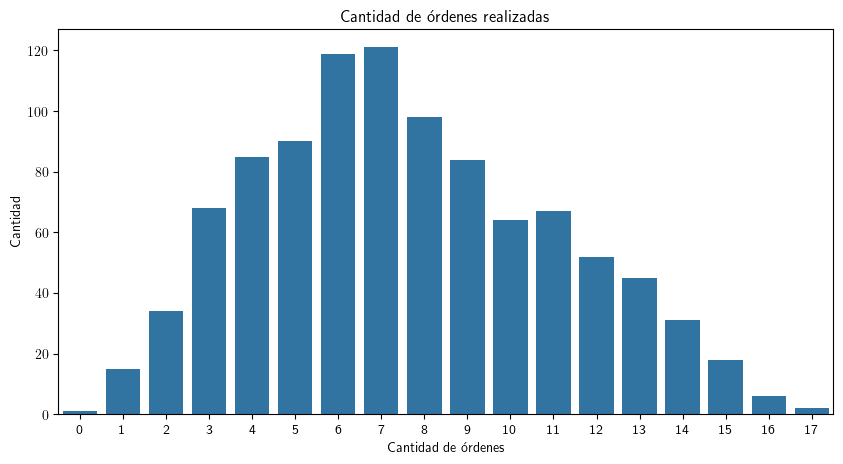

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cantidad_ordenes = [len(solucion.ordenes_realizadas) for (_, solucion) in soluciones]

counts = pd.Series(cantidad_ordenes).value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax)

ax.set_title("Cantidad de órdenes realizadas")
ax.set_xlabel("Cantidad de órdenes")
ax.set_ylabel("Cantidad")

# Save
plt.savefig("graficos/exp1/distribucion_cantidad_ordenes.pdf")

plt.show()

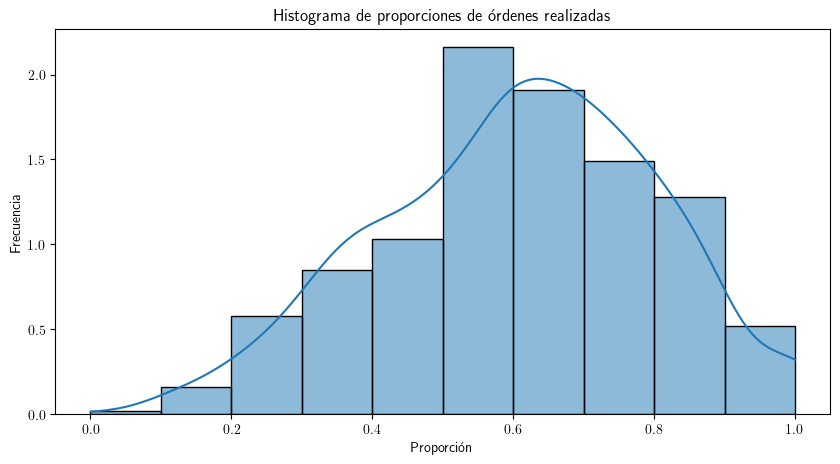

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

proporcion_ordenes = [
    len(solucion.ordenes_realizadas) / len(instancia.ordenes)
    for instancia, (_, solucion) in zip(instancias, soluciones)
]

sns.histplot(proporcion_ordenes, bins=10, ax=ax, kde=True, stat="density")

ax.set_title("Histograma de proporciones de órdenes realizadas")
ax.set_xlabel("Proporción")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/exp1/distribucion_proporcion_ordenes.pdf")

plt.show()

### Distribución de Órdenes por Trabajador